In [1]:
import sys
import networkx as nx
import pickle
import itertools as it

import warnings
warnings.filterwarnings(action='once')


if '/home/anna/Documents/cinnabar' not in sys.path:
    sys.path.insert(1, '/home/anna/Documents/cinnabar')
import cinnabar

if '/home/anna/BioSimSpace/python' not in sys.path:
    sys.path.insert(1, '/home/anna/BioSimSpace/python')
import BioSimSpace as BSS

print(cinnabar.__file__)
print(BSS.__file__)

try:
    import pipeline
except:
    print("adding code to the pythonpath...")
    code = '/home/anna/Documents/code/python'
    if code not in sys.path:
        sys.path.insert(1, code)
    import pipeline

from pipeline import *
from pipeline.analysis import *
from pipeline.prep import *


Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
/home/anna/BioSimSpace/python/BioSimSpace/Parameters/Protocol/_protocol.py:51: ResourceWarning: unclosed file <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
  _sys.stderr = _sys.__stderr__
/home/anna/BioSimSpace/python/BioSimSpace/Parameters/Protocol/_openforcefield.py:88: ResourceWarning: unclosed file <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
  _sys.stderr = _sys.__stderr__


/home/anna/Documents/cinnabar/cinnabar/__init__.py
/home/anna/BioSimSpace/python/BioSimSpace/__init__.py
adding code to the pythonpath...


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb2b9e75ca0>


In [5]:
main_dir = "/backup/anna/benchmark/tyk2"
# main_dir = "/home/anna/Documents/benchmark/tyk2_benchmark"
net_file = "/home/anna/Documents/benchmark/tyk2_benchmark/execution_model/network_lomap.dat"

# choose location for the experimental file
exp_file = "/home/anna/Documents/benchmark/inputs/experimental/tyk2.yml"

if os.path.exists(f"{main_dir}/outputs_extracted/results"):
    results_folder = f"{main_dir}/outputs_extracted/results"
elif os.path.exists(f"{main_dir}/outputs/results"):
    results_folder = f"{main_dir}/outputs/results"
else:
    raise ValueError(f"results directory not found in the {main_dir}. please make sure results were written using the analysis script previously in the pipeline")

output_folder = f"{main_dir}/analysis"

analysis_options = {'estimator': "MBAR", "method":"alchemlyb",
                    "check_overlap":True,
                    "try_pickle":True, 'save_pickle':True,
                    "auto_equilibration": False,
                    "statistical_inefficiency": False,
                    "truncate_percentage": 0,
                    "truncate_keep":"end",
                    "mbar_method": "default"}



In [6]:
analysis_options = analyse._set_options(analysis_options)
file_ext = analyse.file_ext(analysis_options)
file_ext

'MBAR_alchemlyb_default_eqfalse_statsfalse_truncate0end'

In [7]:
all_analysis_object = analysis_network(results_folder,
                                       exp_file=exp_file,
                                       net_file=net_file,
                                       output_folder=output_folder,
                                       file_ext=file_ext
                                        )

# can add any other results files
# all_analysis_object.compute_other_results(file_name=None, name=None)
all_analysis_object.compute()

Graph is not connected enough to compute absolute values


KeyError: 'calc_DG'

no engine specified for plotting, will plot seperate graphs for each self.engines 
no engine specified for plotting, will plot seperate graphs for each self.engines 


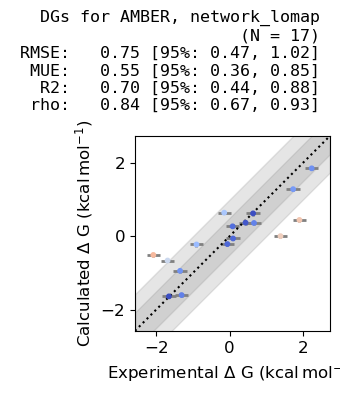

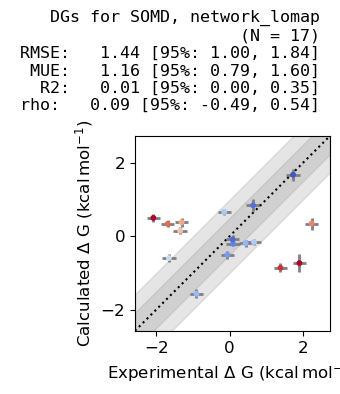

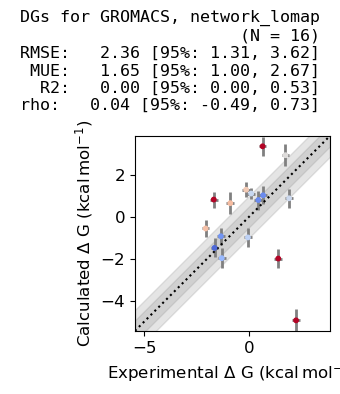

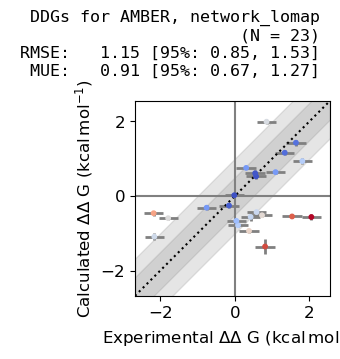

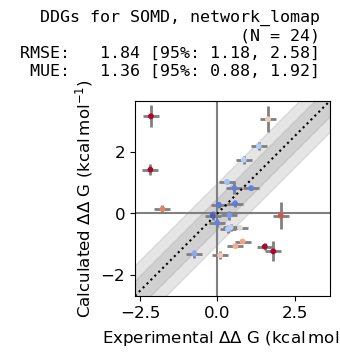

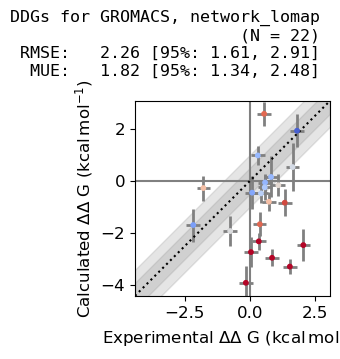

In [20]:
all_analysis_object.plot_scatter_lig(use_cinnabar=True)
all_analysis_object.plot_scatter_pert(use_cinnabar=True)

In [ ]:
ex_outputs_folder = f"{main_dir}/outputs_extracted"

converg_obj = plot_convergence(ex_outputs_folder,
                               perturbations=all_analysis_object.perturbations,
                               engines=all_analysis_object.engines,
                               file_ext=file_ext
                               )

converg_obj.plot_convergence_all()

In [ ]:
all_analysis_object.plot_histogram_legs(free_bound="free")

In [ ]:
all_analysis_object.compute_other_results("/home/anna/Documents/benchmark/inputs/other_computed/fep_data_tyk2_rbfenn_jenke.csv", name="jenke_rbfenn")
all_analysis_object.plot_other_results(name="jenke_rbfenn", engine="SOMD", pert_val="pert")

In [ ]:
eng = "AMBER"
perturbations = []
# ['lig_ejm42~lig_ejm44', 'lig_ejm42~lig_ejm49', 'lig_ejm42~lig_ejm45']
# ['lig_ejm42~lig_ejm49', 'lig_ejm45~lig_ejm55', 'lig_ejm43~lig_ejm50'] #gromacs
# ['lig_ejm45~lig_ejm53', 'lig_ejm44~lig_ejm45', 'lig_ejm31~lig_ejm49'] #somd

for pert in perturbations:
    try:
        all_analysis_object.remove_perturbations(pert)
    except:
        pass
    

all_analysis_object.compute()

# plot scatter plots
all_analysis_object.plot_scatter_lig(engine=eng, use_cinnabar=True)
# all_analysis_object.plot_scatter_pert(engine="AMBER", use_cinnabar=True)
all_analysis_object.plot_outliers(engine=eng, outliers=3, pert_val="val")

In [ ]:
all_analysis_object.calc_mae(pert_val="val")


In [ ]:
res_dir = "/home/anna/Documents/benchmark/tyk2_benchmark/outputs"
res_obj = analysis_network(res_dir,
                            exp_file="/home/anna/Documents/benchmark/inputs/experimental/tyk2.yml",
                            net_file="/home/anna/Documents/benchmark/tyk2_benchmark/execution_model/network_lomap.dat")
res_obj.compute()
print("done")

In [ ]:
res_obj.plot_histogram_sem(pert_val="val")

In [ ]:
res_obj.compute_other_results("/home/anna/Documents/benchmark/inputs/other_computed/fep_data_tyk2_rbfenn_jenke.csv", name="jenke_rbfenn")
res_obj.plot_other_results(name="jenke_rbfenn", engine="SOMD", pert_val="val", outliers=3)

In [ ]:
res_obj.calc_mae(pert_val="pert")

In [ ]:
res_obj.plot_histogram_pert()

In [ ]:
# for prot, net in it.product(["tyk2","p38","mcl1"],["rbfenn","lomap"]):

#     results_files = ["/home/anna/Documents/code/test/final_summary_SOMD_MBAR_alchemlyb_benchmark.csv"]
#     engine = "SOMD"
#     output_folder = "/home/anna/Documents/code/test"
#     net_file = f"/home/anna/Documents/benchmark/{prot}_benchmark/execution_model/network_{net}.dat"
#     weight_file = f"/home/anna/Documents/benchmark/{prot}_benchmark/execution_model/network_{net}_scores.dat"

#     perturbations, ligands, mod_results_files = get_info_network(results_files, net_file, extra_options={"engine":engine})

#     graph_x = graph(ligands, perturbations)
#     graph_x.add_weight(weight_file)
#     # graph_x.draw_graph()
#     avg_weighted = graph_x.get_average_weighted_simple_paths()
#     print(f"{prot} {net} is {avg_weighted}")

#     with open(f"{output_folder}/graph_{prot}_{net}.pickle", 'wb') as handle:
#         pickle.dump(graph_x.graph, handle)

# # cycles = graph.cycle_closures()
# # print(cycles)

# # nx.get_edge_attributes(graph_x.graph, "weight")

# # print(len(perturbations))


# # with open(f"{output_folder}/graph_tyk2_rbfenn.pickle", "rb") as file:
# #     graph_t = pickle.load(file)
# # print(type(graph_t))
# # nx.get_edge_attributes(graph_t, "weight")

In [ ]:
# import MDAnalysis
# from MDAnalysis.tests.datafiles import PSF,DCD,CRD
# u = MDAnalysis.Universe(PSF,DCD)
# ref = MDAnalysis.Universe(PSF,DCD)     # reference closed AdK (1AKE) (with the default ref_frame=0)
# #ref = MDAnalysis.Universe(PSF,CRD)    # reference open AdK (4AKE)

# import MDAnalysis.analysis.rms

# R = MDAnalysis.analysis.rms.RMSD(u, ref,
#            select="backbone",             # superimpose on whole backbone of the whole protein
#            groupselections=["backbone and (resid 1-29 or resid 60-121 or resid 160-214)",   # CORE
#                             "backbone and resid 122-159",                                   # LID
#                             "backbone and resid 30-59"])                                    # NMP
# R.run()

# import matplotlib.pyplot as plt
# rmsd = R.rmsd.T   # transpose makes it easier for plotting
# time = rmsd[1]
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# ax.plot(time, rmsd[2], 'k-',  label="all")
# ax.plot(time, rmsd[3], 'k--', label="CORE")
# ax.plot(time, rmsd[4], 'r--', label="LID")
# ax.plot(time, rmsd[5], 'b--', label="NMP")
# ax.legend(loc="best")
# ax.set_xlabel("time (ps)")
# ax.set_ylabel(r"RMSD ($\AA$)")
# fig.savefig("rmsd_all_CORE_LID_NMP_ref1AKE.pdf")